<a href="https://colab.research.google.com/github/cimbelli/Burnt_Area_Mapping/blob/main/ba_1.7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Stima delle aree percorse da incendi per mese e regione

In [14]:
import os
import ee
import pandas as pd
import json
import geopandas as gpd
import requests
import calendar
from shapely.geometry import shape
from shapely.geometry import mapping

#ee.Authenticate()
ee.Initialize()
!pip install rasterstats
!pip install wget
import wget
from rasterstats import zonal_stats

# scegli quale statistica estrarre per regione e mese
statistiche = "min mean max median"
stat_map = "median"
class_intervals = [0, 20, 25, 30, 35, 40, 45, 50, 55, 60, 100]

In [2]:
anni = [2020,] #[2019, 2020, 2021, 2022, 2023]
mesi = [8,] #[6,7,8,9]

In [4]:
platform = 'Landsat' # 'Landsat' or 'Sentinel'

In [33]:
import folium
from folium import plugins

def add_ee_layer(self, ee_image_object, vis_params, name):
    map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
    folium.raster_layers.TileLayer(
      tiles=map_id_dict['tile_fetcher'].url_format,
      attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
      name=name,
      overlay=True,
      control=True
    ).add_to(self)

def scarica(lyr, name):#, aoi):
    url = lyr.getDownloadUrl({
        'name': name[:-4],
        #'bands': ['vis-red', 'vis-green', 'vis-blue'],
        #'region': aoi,
        'scale': 30,
        'format': 'GEO_TIFF',
        'formatOptions': {'cloudOptimized': True},
        'maxPixels': 1e9,
    })
    response = requests.get(url)
    with open(name, 'wb') as fd:
        fd.write(response.content)
    return None


# conversione raster 2 vector con eliminazione di pixel isolati
def ras2vec(im, k, thres):
    kernel = ee.Kernel.square(radius=k)
    smoothed_image = im.reduceNeighborhood(reducer=ee.Reducer.mean(),kernel=kernel)
    #threshold = 0.5  # Adjust this threshold as needed
    filtered_image = smoothed_image.gt(thres)

    connected_pixels = filtered_image.connectedComponents(connectedness=kernel, maxSize=264) #ee.Kernel.square(1),
    #maxSize=64  # Maximum size of connected components to retain
#)
    vectors = connected_pixels.reduceToVectors(
        geometry=connected_pixels.geometry(),
        crs=im.projection(),
        scale=im.projection().nominalScale(),
        maxPixels=1e13
        )

# geometry=filtered_image.geometry(),
    # Convert Earth Engine FeatureCollection to a list of GeoJSON features
    features = vectors.getInfo()['features']
    geometries = [shape(feature['geometry']) for feature in features]
    gj = gpd.GeoDataFrame(geometry=geometries)
    #gdf.to_file("output.geojson", driver="GeoJSON")

    return gj



# Add custom basemaps to folium
basemaps = {
    'Google Maps': folium.TileLayer(
        tiles = 'https://mt1.google.com/vt/lyrs=m&x={x}&y={y}&z={z}',
        attr = 'Google',
        name = 'Google Maps',
        overlay = True,
        control = True,
        show=False
    ),
    'Google Satellite': folium.TileLayer(
        tiles = 'https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}',
        attr = 'Google',
        name = 'Google Satellite',
        overlay = True,
        control = True,
        show=False
    ),
    'Google Terrain': folium.TileLayer(
        tiles = 'https://mt1.google.com/vt/lyrs=p&x={x}&y={y}&z={z}',
        attr = 'Google',
        name = 'Google Terrain',
        overlay = True,
        control = True,
        show=False
    ),
    'Google Satellite Hybrid': folium.TileLayer(
        tiles = 'https://mt1.google.com/vt/lyrs=y&x={x}&y={y}&z={z}',
        attr = 'Google',
        name = 'Google Satellite',
        overlay = True,
        control = True,
        show=False
    ),
    'Esri Satellite': folium.TileLayer(
        tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
        attr = 'Esri',
        name = 'Esri Satellite',
        overlay = True,
        control = True,
        show=False
    )
}

In [6]:
# carica lo shape delle regioni
nomereg = 'reg1.geojson'
if not(os.path.isfile(nomereg)):
  wget.download('https://raw.githubusercontent.com/cimbelli/Burnt_Area_Mapping/main/' + nomereg)
g = open(nomereg)
cc = json.load(g)

gdf = gpd.read_file(nomereg)
centro = gdf.to_crs(epsg=3857).centroid.to_crs(gdf.crs)
gdf["lon"] = centro.x
gdf["lat"] = centro.y

<Axes: >

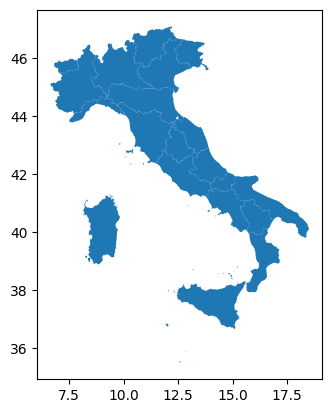

In [7]:
gdf.plot()

In [8]:
def maskS2sr(image):
    cloudBitMask = ee.Number(2).pow(10).int()
    cirrusBitMask = ee.Number(2).pow(11).int()
    qa = image.select('QA60')
    mask = qa.bitwiseAnd(cloudBitMask).eq(0).And(qa.bitwiseAnd(cirrusBitMask).eq(0))
    return image.updateMask(mask).copyProperties(image, ["system:time_start"])

def maskL8sr(image):
    cloudShadowBitMask = 1 << 3
    cloudsBitMask = 1 << 5
    snowBitMask = 1 << 4
    qa = image.select('pixel_qa')
    mask = qa.bitwiseAnd(cloudShadowBitMask).eq(0).And(qa.bitwiseAnd(cloudsBitMask).eq(0)).And(qa.bitwiseAnd(snowBitMask).eq(0))
    return image.updateMask(mask).select("B[0-9]*").copyProperties(image, ["system:time_start"])

def cloudMask(image):
  scl = image.select('SCL')
  mask = scl.eq(3) or (scl.gte(7) and (scl.lte(10)))
  return image.updateMask(mask.eq(0))


In [34]:
import geemap
thresholds = ee.Image([-1000, -251, -101, 99, 269, 439, 659, 2000])
sld_intervals = '''
<RasterSymbolizer>
  <ColorMap type="intervals" extended="false">
    <ColorMapEntry color="#ffffff" quantity="-500" label="-500"/>
    <ColorMapEntry color="#7a8737" quantity="-250" label="-250"/>
    <ColorMapEntry color="#acbe4d" quantity="-100" label="-100"/>
    <ColorMapEntry color="#0ae042" quantity="100" label="100"/>
    <ColorMapEntry color="#fff70b" quantity="270" label="270"/>
    <ColorMapEntry color="#ffaf38" quantity="440" label="440"/>
    <ColorMapEntry color="#ff641b" quantity="660" label="660"/>
    <ColorMapEntry color="#a41fd6" quantity="2000" label="2000"/>
  </ColorMap>
</RasterSymbolizer>
'''
sld_incendi = '''
<RasterSymbolizer>
  <ColorMap type="intervals" extended="false">
    <ColorMapEntry color="#ffffff" quantity="-500" label="-500"/>
    <ColorMapEntry color="#ff641b" quantity="200" label="200"/>
    <ColorMapEntry color="#a41fd6" quantity="2000" label="2000"/>
  </ColorMap>
</RasterSymbolizer>
'''

CLASS_NAMES = ['water','trees','grass','flooded_vegetation','crops','shrub_and_scrub','built','bare','snow_and_ice']
VIS_PALETTE = ['419bdf','397d49','88b053','7a87c6','e49635','dfc35a','c4281b','a59b8f', 'b39fe1']
dwVisParams = {'min': 0,'max': 8,'palette': [
    '#419BDF', '#397D49', '#88B053', '#7A87C6', '#E49635', '#DFC35A',
    '#C4281B', '#A59B8F', '#B39FE1']}

for i in range(len(gdf)):           # for all the records

    reg = gdf['COD_REG'].iloc[i]
    nomereg = gdf['DEN_REG'].iloc[i]
    reg1 = ('0' if reg < 10 else '') + str(reg)
    if reg == 17:    # nel caso della Basilicata
        print('========', nomereg ,'========')

        ee_fc = geemap.geopandas_to_ee(gdf.iloc[[i]])
        lat = gdf['geometry'].centroid.y.iloc[i]
        lon = gdf['geometry'].centroid.x.iloc[i]
        #ee_fc = geemap.geopandas_to_ee(gdf.iloc[[i]])

        for anno in anni:
            anno1 = str(anno)[-2:]
            print('---',anno,'---')

            for mese in mesi:
                mese1 = ('0' + str(mese)) if mese < 10 else str(mese)
                mese2 = ('0' + str(mese+1)) if mese+1 < 10 else str(mese+1)



                #dw = ee.ImageCollection('GOOGLE/DYNAMICWORLD/V1').filterDate(str(anno) + '-01-01', str(anno) + '-' + mese1 +
                #                '-' + str(calendar.monthrange(anno, mese)[1]))

                s2_pre =  ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED').filterDate(str(anno) +
                                '-' + mese1 + '-01', str(anno) + '-' + mese1 +'-' + str(calendar.monthrange(anno, mese)[1]))
                s2_post = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED').filterDate(str(anno) +
                                '-' + mese2 + '-01', str(anno) + '-' + mese2 +'-' + str(calendar.monthrange(anno, mese+1)[1]))

                #imageId = s2Image.get('system:index')
                dw = ee.ImageCollection('GOOGLE/DYNAMICWORLD/V1').filterDate(str(anno) + '-' + mese1 + '-01', str(anno) + '-' + mese1 +
                                '-' + str(calendar.monthrange(anno, mese)[1]))
                lc = dw.select('label').mode().clip(ee_fc)
                trees = dw.select('label').mode().clip(ee_fc).eq(1)
                crops = dw.select('label').mode().clip(ee_fc).eq(4)
                shrubs = dw.select('label').mode().clip(ee_fc).eq(5)
                trees_shrubs = trees.Or(shrubs)
                #probabilityImage = dwImage.clip(ee_fc)#.select('label')
                #top1Probability = probabilityImage.reduce(ee.Reducer.max()).clip(ee_fc)

                #landcover = dw.filterBounds(ee_fc).first().clip(ee_fc)   #.visualize(min=0, max=8, palette=VIS_PALETTE)
                #treecover = landcover.updateMask(landcover.eq(1))
                #forest = corine.updateMask(corine.gte(23).and(corine.lte(32)))

                preNBR = s2_pre.filterBounds(ee_fc).map(cloudMask).median().clip(ee_fc).normalizedDifference(['B8', 'B12']) #.select(['B8','B12'])
                postNBR = s2_post.filterBounds(ee_fc).map(cloudMask).median().clip(ee_fc).normalizedDifference(['B8', 'B12'])

                dNBR_unscaled = preNBR.subtract(postNBR)
                dNBR = dNBR_unscaled.multiply(1000)

                # Seperate result into 8 burn severity classes
                thresholds = ee.Image([-1000, -251, -101, 99, 269, 439, 659, 2000])
                classified = dNBR.lt(thresholds).reduce('sum').toInt()

                dNBRs = dNBR.sldStyle(sld_intervals)
                dNBRs1 = dNBR.gt(200)

                out = dNBRs1.And(trees_shrubs)

                vec = ras2vec(out, 1, 0.5)
                vec.to_file("output.geojson", driver="GeoJSON")
                print('db')


                #scarica(dNBR, "dNBR_r" + reg1 + "_" + anno1 + mese1 + ".tif", region)
                #print("dNBR_r" + reg1 + "_" + anno1 + mese1 + ".tif")

            #Map.addLayer(image, {bands: ['B8', 'B11', 'B2'], min: 0, max: [5000, 3000, 2000]}, 'Sentinel-2')


            #break
        #break
    #break

======== Basilicata ========
--- 2020 ---


EEException: ignored

In [ ]:


kernel = ee.Kernel.square(radius=10)
smoothed_image = out.reduceNeighborhood(reducer=ee.Reducer.mean(),kernel=kernel)
#threshold = 0.5  # Adjust this threshold as needed
filtered_image = smoothed_image.gt(5)

connected_pixels = filtered_image.connectedComponents(connectedness=ee.Kernel.square(10), maxSize=1024) #ee.Kernel.square(1),
#maxSize=64  # Maximum size of connected components to retain
#)
conn = connected_pixels.select(0).gt(0.5)
vectors = conn.reduceToVectors(
    geometry=ee_fc,
    crs=out.projection(),
    scale=out.projection().nominalScale(),
    maxPixels=1000)

# Convert Earth Engine FeatureCollection to a list of GeoJSON features
features = vectors.getInfo()['features']
geometries = [shape(feature['geometry']) for feature in features]
gj = gpd.GeoDataFrame(geometry=geometries)

In [64]:
from IPython.display import display
from IPython.display import Image
display(filtered_image)
#display(Image(url=connected_pixels.visualize({}).getThumbURL()))

In [61]:
map_s2.addLayer(out, {}, 'incendi boschivi')
map_s2.addLayer(connected_pixels.select(0), {}, 'conn')
display(map_s2)

Map(bottom=3175752.0, center=[40.00986677798875, 15.699553817831767], controls=(WidgetControl(options=['positi…

In [13]:
from geemap import geojson_to_ee, ee_to_geojson
map_s2 = geemap.Map(center=[lat, lon], zoom=10)
map_s2.addLayer(dNBRs, {}, 'dNBR classified')
map_s2.addLayer(dNBRs1, {}, 'incendi')

#map_s2.centerObject(lc);
#map_s2.addLayer(lc, visualization, 'Landcover')
####################################################
map_s2.addLayer(lc, dwVisParams, 'DW')
map_s2.addLayer(trees_shrubs, {}, 'Trees or Shrubs')
map_s2.addLayer(out, {}, 'incendi boschivi')
####################################################
# carica lo shape degli incendi
nomeinc = 'r17_08-2020.geojson'
if not(os.path.isfile(nomeinc)):
  wget.download('https://raw.githubusercontent.com/cimbelli/Burnt_Area_Mapping/main/' + nomeinc)

ee_inc = geojson_to_ee(nomeinc)
map_s2.addLayer(ee_inc, {}, 'incendi 2020')
####################################################


display(map_s2)


Map(center=[40.49981398677227, 16.08172032334126], controls=(WidgetControl(options=['position', 'transparent_b…

In [ ]:
scarica(dNBRs, "dNBRs_r" + reg1 + "_" + anno1 + mese1 + ".tif")#, region.getInfo())

EEException: ignored

In [ ]:
#import geemap
map_s2 = geemap.Map(center=[37, 14], zoom=10)
visualization = {
    'min': -1000.0,
    'max': 1000, #[5000, 2000,3000],
    'bands': ['B8', 'B11', 'B12'],
    'scale': 20,
}
#scarica(image, "s2", ee.Geometry.BBox(8, 45, 8.1, 45.1))

thresholds = ee.Image([-1000, -251, -101, 99, 269, 439, 659, 2000])
classified = dNBR.lt(thresholds).reduce('sum').toInt()


sld_intervals = '''
<RasterSymbolizer>
  <ColorMap type="intervals" extended="false">
    <ColorMapEntry color="#ffffff" quantity="-500" label="-500"/>
    <ColorMapEntry color="#7a8737" quantity="-250" label="-250"/>
    <ColorMapEntry color="#acbe4d" quantity="-100" label="-100"/>
    <ColorMapEntry color="#0ae042" quantity="100" label="100"/>
    <ColorMapEntry color="#fff70b" quantity="270" label="270"/>
    <ColorMapEntry color="#ffaf38" quantity="440" label="440"/>
    <ColorMapEntry color="#ff641b" quantity="660" label="660"/>
    <ColorMapEntry color="#a41fd6" quantity="2000" label="2000"/>
  </ColorMap>
</RasterSymbolizer>
'''
# Add the image to the map using both the color ramp and interval schemes.

dNBRs = dNBR.sldStyle(sld_intervals)

map_s2.addLayer(dNBRs, {}, 'dNBR classified')

scarica(dNBRs, "dNBRs_r" + reg1 + "_" + anno1 + mese1 + ".tif", region.getInfo())

#map_s2.add_layer(classified, visualization, 'false color composite')

# add legend to map (alternatively you can also print the legend to the console)
#map_s2.add(legend)

display(map_s2)

Map(center=[37, 14], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(chil…

In [ ]:
region.getInfo()


{'geodesic': False,
 'type': 'Polygon',
 'coordinates': [[[14, 37], [14.5, 37], [14.5, 37.5], [14, 37.5], [14, 37]]]}

In [ ]:
def scarica(lyr, name, aoi):
    url = lyr.getDownloadUrl({
        'name': name[:-4],
        #'bands': ['vis-red', 'vis-green', 'vis-blue'],
        'region': aoi,
        'scale': 30,
        'format': 'GEO_TIFF',
        'formatOptions': {'cloudOptimized': True},
        'maxPixels': 1e9,
    })
    response = requests.get(url)
    with open(name, 'wb') as fd:
        fd.write(response.content)
    return None

scarica(dNBRs, "dNBRs_r" + reg1 + "_" + anno1 + mese1 + ".tif", region)

In [ ]:
var vectorized = dNBR.reduceToVectors({
  geometry: classifiedImage.geometry(),
  scale: scale,
  geometryType: 'polygon',
  eightConnected: false,
  labelProperty: 'class', // Property to store class information
  reducer: ee.Reducer.mean(), // Use a reducer to aggregate values if needed
  maxPixels: 1e13
});

In [ ]:
#import geemap
visualization = {
    'min': 0.0,
    'max': [5000, 2000,3000],
    'bands': ['B8', 'B11', 'B12'],
    'scale': 300,
}

m = geemap.Map()
m.set_center(12.277, 45.7009, 12)
m.add_layer(image, visualization, 'Sentinel-2')
m

EEException: ignored

In [ ]:
for i in range(len(cc['features'])):           # for all the records

    reg = cc['features'][i]['properties']['COD_REG']
    nomereg = cc['features'][i]['properties']['DEN_REG']
    reg1 = ('0' if reg < 10 else '') + str(reg)

    coords = cc['features'][i]['geometry']['coordinates']
    fc = ee.FeatureCollection(cc['features'])

    print('========', nomereg ,'========')

    lat = gdf[gdf['COD_REG']== id1]['lat'].values[0]
    lon = gdf[gdf['COD_REG']== id1]['lon'].values[0]

    minx = gdf[gdf['COD_REG']== id1].geometry.bounds.minx.values[0]
    maxx = gdf[gdf['COD_REG']== id1].geometry.bounds.maxx.values[0]
    miny = gdf[gdf['COD_REG']== id1].geometry.bounds.miny.values[0]
    maxy = gdf[gdf['COD_REG']== id1].geometry.bounds.maxy.values[0]

    region = ee.Geometry.BBox(minx, miny, maxx, maxy)

    for anno in anni:
        anno1 = str(anno)[-2:]
        print('---',anno,'---')

        for mese in mesi:
            mese2 = ('0' + str(mese + 1)) if mese < 9 else str(mese + 1)
            nome_img = 'BA_' + nomereg + '_'+ str(anno) + '_'+ mese2 + '.tif'

            if not(os.path.isfile(nome_img)):

                if (platform == 'Sentinel' or platform == 's2'):
                    ImCol = 'COPERNICUS/S2_SR_HARMONIZED'
                    pl = 'Sentinel-2'
                else:
                    ImCol = 'LANDSAT/LC08/C02/T1_S2'
                    pl = 'Landsat 8'
                print(ee.String('Data selected for analysis: ').cat(pl))
                print(ee.String('Fire incident occurred between ').cat(prefire_end).cat(' and ').cat(postfire_start))
                area = ee.FeatureCollection(geometry)
                Map.centerObject(area)
                imagery = ee.ImageCollection(ImCol)
                prefireImCol = ee.ImageCollection(imagery
                    .filterDate(prefire_start, prefire_end)
                    .filterBounds(area))
                postfireImCol = ee.ImageCollection(imagery
                    .filterDate(postfire_start, postfire_end)
                    .filterBounds(area))
                print("Pre-fire Image Collection: ", prefireImCol)
                print("Post-fire Image Collection: ", postfireImCol)

#######################################


                L9 = ee.ImageCollection('LANDSAT/LC09/C02/T1_L2').filterDate(str(anno) +
                            '-' + mese2 + '-01', str(anno) + '-' + mese2 +'-' + str(calendar.monthrange(anno, mese)[1]))
                L8 = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2').filterDate(str(anno) +
                            '-' + mese2 + '-01', str(anno) + '-' + mese2 +'-' + str(calendar.monthrange(anno, mese)[1]))


                bands = ['ST_B10', 'QA_PIXEL']
                bandName = ['ST', 'QA_PIXEL']
                filtered_L9 = L9.filter(ee.Filter.lt('CLOUD_COVER', 40)).select(bands, bandName)#.map(cloudMask)
                filtered_L8 = L8.filter(ee.Filter.lt('CLOUD_COVER', 40)).select(bands, bandName)#.map(cloudMask)
                LandsatColl = filtered_L8.merge(filtered_L9)
                LandsatColl = LandsatColl.select('ST').filterBounds(region)

#######################################



======== Milano ========
--- 2019 ---


AssertionError: ignored

In [ ]:
             # zonal stats per sezioni
#              print('scarico immagine', comune, anno, "n° acquisizioni", n_img)

              scarica(thermal, nome_img, region)
            else:
              print('nessuna immagine nel periodo selezionato')
              continue
        else:
            print(nome_img, 'già presente')

# calcola le statistiche zonali per anno
        stats = zonal_stats(df_sez11, nome_img, stats=statistiche)
        sdf = pd.DataFrame(stats)
        sdf = sdf.round(2)
        sdf.rename(columns={'min':'min'+anno1,'max':'max'+anno1,'median':'median'+anno1,'mean':'mean'+anno1 }, inplace=True)
        sdf['n_img'+anno1] = n_img
        sdf['class'+anno1] = pd.cut(sdf[stat_map + anno1], bins=class_intervals, labels=False)
        df_sez11 = pd.concat([df_sez11, sdf], axis=1)
        stats.clear()

        sdf2 = df_sez11.drop(['COD_REG','PRO_COM','P14','P15','P28','P29'], axis=1)
        sdf3 = sdf2.drop(['geometry'], axis=1)
        sdf3.to_excel(comune + '_stats.xlsx', index=False)

        # Crea la mappa per il comune e in estate
        m = folium.Map(location=(centro1.y[0],centro1.x[0] ), tiles="cartodb positron", zoom_start=12)
        folium.Choropleth(
            geo_data=sdf2,
            name ="Temperature SUPERFICIALI per sezione 2011 - " + comune + '-' + 'estate'+ str(anno),
            data=sdf2,
            columns=["SEZ", stat_map + anno1,"Tot_residenti","Bambini_0-9","Anziani_>70"],
            key_on="feature.properties.SEZ",
            fill_color= 'RdYlGn_r', #'YlOrRd',
            bins=[20, 25, 30, 35, 40, 45, 50, 55, 60, 100],
            fill_opacity=0.7,
            line_opacity=0.2,
            legend_name="Temperatura (" + stat_map + ") superficiale estiva per sezioni 2011",
        ).add_to(m)

        style_function = lambda x: {'fillColor': '#ffffff', 'color':'#000000', 'fillOpacity': 0.1, 'weight': 0.1}
        SuburbName = folium.features.GeoJson(sdf2, style_function=style_function,
            control=False, tooltip=folium.features.GeoJsonTooltip(
                fields=['SEZ', stat_map + anno1, "Tot_residenti","Bambini_0-9","Anziani_>70"],
                style=("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;")
            )
        )
        m.add_child(SuburbName)
        m.keep_in_front(SuburbName)
        basemaps['Google Satellite'].add_to(m)

        folium.LayerControl().add_to(m)
        m.save(comune + '_' + str(anno) + '.html')



In [ ]:
# scaricare i file html e xlsx sul pc locale
from google.colab import files
import glob

html_list = glob.glob('*.html')
xlsx_list = glob.glob('*.xlsx')

for file_h in html_list:
  files.download(file_h)

for file_x in xlsx_list:
  files.download(file_x)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
for file_x in xlsx_list:
  files.download(file_x)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>